In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler

from pytorch_tabnet.tab_network import TabNetEncoder

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Create technical indicator features
data.ta.strategy("all")

print(f"Data shape after adding features: {data.shape}")
print("A peek at the new feature columns:")
data.tail()

0it [00:13, ?it/s]


AttributeError: Can only use .str accessor with Index, not MultiIndex

In [2]:
STOCK_TICKER = 'MSFT'
# Set the end date to get data up to the last trading day before our "current date"
END_DATE = '2025-08-09'

# Download historical data
# MODIFICATION: Add group_by='column' to prevent a MultiIndex column structure
data = yf.download(
    tickers=STOCK_TICKER,
    start='2015-01-01',
    end=END_DATE,
    group_by='column'
)

print(f"Data for {STOCK_TICKER} downloaded. Shape: {data.shape}")
print("Column names:", data.columns.to_list())
print("\nLast 5 rows of data:")
data.tail()

[*********************100%***********************]  1 of 1 completed

Data for MSFT downloaded. Shape: (2666, 5)
Column names: [('Close', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Open', 'MSFT'), ('Volume', 'MSFT')]

Last 5 rows of data:


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2025-08-04,535.640015,538.250000,528.130005,528.270020,25349000
2025-08-05,527.750000,537.299988,527.239990,537.179993,19171600
2025-08-06,524.940002,531.700012,524.030029,530.900024,21355700
2025-08-07,520.840027,528.090027,517.549988,526.799988,16079100
2025-08-08,522.039978,524.659973,519.409973,522.599976,15516600


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np

# === PARAMETERS ===
STOCK_TICKER = 'MSFT'
END_DATE = '2025-08-09'

# === DATA LOADING ===
data = yf.download(
    tickers=STOCK_TICKER,
    start='2015-01-01',
    end=END_DATE,
    group_by='column'
)

# Keep only essential columns
data = data[['Open', 'High', 'Low', 'Close',  'Volume']]

print(f"Data for {STOCK_TICKER} downloaded. Shape: {data.shape}")

# === FEATURE ENGINEERING ===

# RSI (Relative Strength Index)
def compute_rsi(series, length=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = compute_rsi(data['Close'], 14)

# MACD (12, 26, 9)
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# VWAP (Volume Weighted Average Price)
vwap = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()
data['VWAP'] = vwap

# Rolling Standard Deviation (Volatility)
data['Rolling_STD_14'] = data['Close'].rolling(window=14).std()

# Drop rows with NaN values after indicator calculations
data.dropna(inplace=True)

print("Feature engineering complete. Final shape:", data.shape)
print(data.tail())


[*********************100%***********************]  1 of 1 completed

Data for MSFT downloaded. Shape: (2666, 5)
Feature engineering complete. Final shape: (2653, 10)
Price             Open        High         Low       Close    Volume  \
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT   
Date                                                                   
2025-08-04  528.270020  538.250000  528.130005  535.640015  25349000   
2025-08-05  537.179993  537.299988  527.239990  527.750000  19171600   
2025-08-06  530.900024  531.700012  524.030029  524.940002  21355700   
2025-08-07  526.799988  528.090027  517.549988  520.840027  16079100   
2025-08-08  522.599976  524.659973  519.409973  522.039978  15516600   

Price          RSI_14       MACD MACD_Signal        VWAP Rolling_STD_14  
Ticker                                                                   
Date                                                                     
2025-08-04  73.188124  10.719843    9.598225  181.855600       9.643501  
2025-08-05  65.370157  10.7181

In [8]:
# The target variable (y) is the closing price of the next day.
data['Target'] = data['Close'].shift(-1)

# Drop the last row since it will have a NaN value in the 'Target' column
data.dropna(inplace=True)

# The features (X) are all columns except the target.
# We also drop 'Close' from the features to prevent the model from simply learning
# that tomorrow's price is very close to today's price (data leakage).
X = data.drop(columns=['Target', 'Close'])
y = data['Target']

print(f"Shape of feature set X: {X.shape}")
print(f"Shape of target y: {y.shape}")
print("\nFeatures being used for training:")
print(X.columns.to_list())

Shape of feature set X: (2652, 9)
Shape of target y: (2652,)

Features being used for training:
[('Open', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Volume', 'MSFT'), ('RSI_14', ''), ('MACD', ''), ('MACD_Signal', ''), ('VWAP', ''), ('Rolling_STD_14', '')]


In [9]:
# Split data chronologically (85% train, 15% validation)
train_size = int(len(X) * 0.85)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert data to PyTorch Tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).view(-1, 1)

print(f"Training data shape: {X_train_tensor.shape}")
print(f"Validation data shape: {X_val_tensor.shape}")

Training data shape: torch.Size([2254, 9])
Validation data shape: torch.Size([398, 9])


In [31]:
# --- FINAL Corrected Code for the Model Definition Cell ---

class HybridDNNTabNet(nn.Module):
    def __init__(self, input_dim, tabnet_dim=32, dnn_hidden_dim=64):
        super(HybridDNNTabNet, self).__init__()
        
        # Branch 1: TabNet Encoder
        # FINAL FIX: Set n_d and n_a to 32 so the output dimension is 32.
        # This will make the TabNet branch's output match the DNN branch's output.
        self.tabnet_encoder = TabNetEncoder(
            input_dim=input_dim,
            output_dim=tabnet_dim,
            n_d=32, # This controls the feature output size of each step
            n_a=32, # Should be equal to n_d
            n_steps=4,
            gamma=1.3,
            n_independent=2,
            n_shared=2,
            epsilon=1e-15,
            virtual_batch_size=128,
            momentum=0.02
        )

        # Branch 2: Standard DNN
        self.dnn = nn.Sequential(
            nn.Linear(input_dim, dnn_hidden_dim), nn.ReLU(), nn.BatchNorm1d(dnn_hidden_dim), nn.Dropout(0.3),
            nn.Linear(dnn_hidden_dim, dnn_hidden_dim // 2), nn.ReLU(), nn.BatchNorm1d(dnn_hidden_dim // 2), nn.Dropout(0.3)
        )
        
        # Head: Combination Layer
        # Now expects 32 (from TabNet) + 32 (from DNN) = 64 features.
        self.head = nn.Sequential(
            nn.Linear(tabnet_dim + dnn_hidden_dim // 2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # The encoder returns a list of tensors (one for each step) and the masks
        list_of_tabnet_outputs, _ = self.tabnet_encoder(x)
        
        # Sum the outputs of all the TabNet steps to get a single tensor
        tabnet_output = sum(list_of_tabnet_outputs)
        
        # Process through DNN branch
        dnn_output = self.dnn(x)
        
        # Concatenate the outputs of the two branches. This will now be a tensor with 64 features.
        combined = torch.cat([tabnet_output, dnn_output], dim=1)
        
        # Pass through the final head to get the prediction
        prediction = self.head(combined)
        return prediction

In [33]:
# Hyperparameters
input_dim = X_train_scaled.shape[1]
learning_rate = 0.005
epochs = 100 # Can be increased for potentially better performance
batch_size = 256

# Model, Loss, and Optimizer
model = HybridDNNTabNet(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Starting model training...")
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Model training complete.")

Starting model training...


Epoch [5/100], Loss: 1885.2694
Epoch [10/100], Loss: 299.2225
Epoch [15/100], Loss: 98.1364
Epoch [20/100], Loss: 224.3382
Epoch [25/100], Loss: 119.7104
Epoch [30/100], Loss: 202.8375
Epoch [35/100], Loss: 120.7243
Epoch [40/100], Loss: 67.7891
Epoch [45/100], Loss: 107.2405
Epoch [50/100], Loss: 135.6227
Epoch [55/100], Loss: 58.8999
Epoch [60/100], Loss: 173.7058
Epoch [65/100], Loss: 114.8621
Epoch [70/100], Loss: 47.7171
Epoch [75/100], Loss: 101.3674
Epoch [80/100], Loss: 107.4660
Epoch [85/100], Loss: 108.8302
Epoch [90/100], Loss: 223.2670
Epoch [95/100], Loss: 76.7670
Epoch [100/100], Loss: 59.7217
Model training complete.



Validation Root Mean Squared Error (RMSE): $20.16


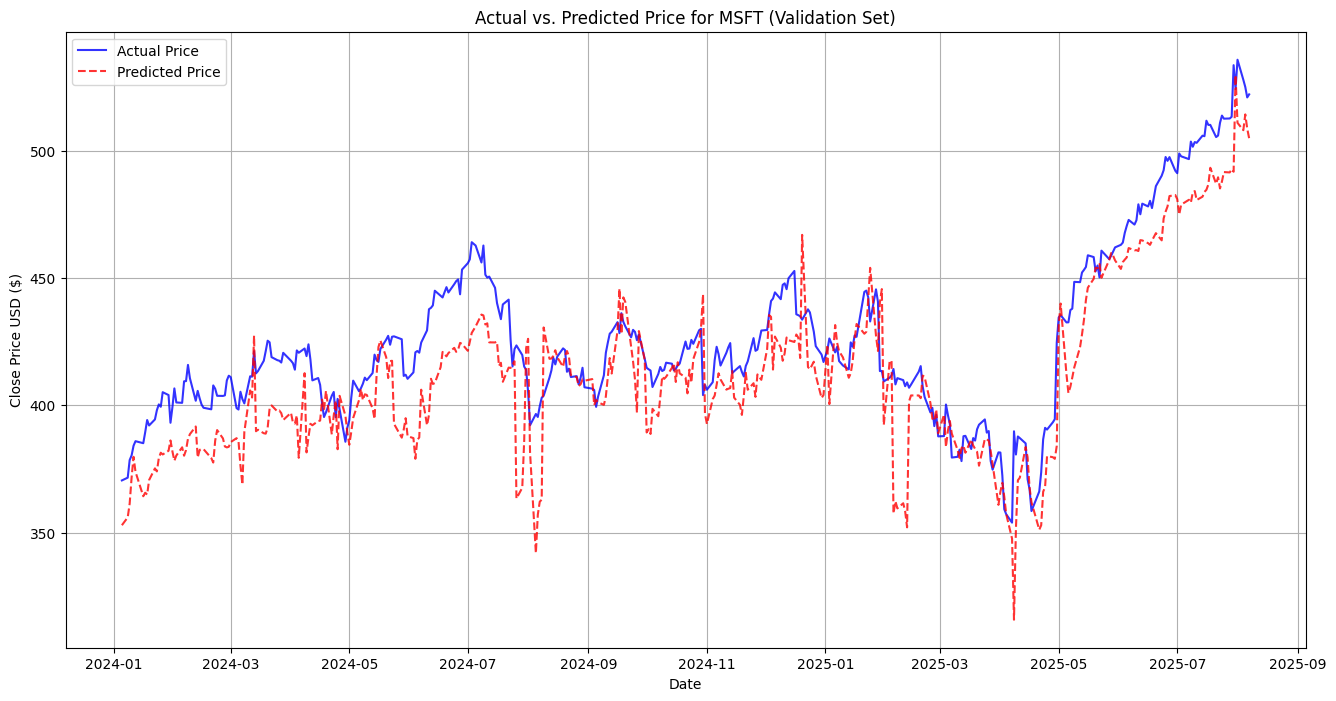

In [34]:
# --- Code for Cell 8 ---

model.eval() # Set the model to evaluation mode
with torch.no_grad(): # No need to calculate gradients during evaluation
    predicted_prices_tensor = model(X_val_tensor)

predicted_prices = predicted_prices_tensor.numpy().flatten()
actual_prices = y_val.values

# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Actual_Price': actual_prices,
    'Predicted_Price': predicted_prices
}, index=y_val.index)

# Calculate evaluation metric (RMSE)
val_rmse = np.sqrt(np.mean((results_df['Actual_Price'] - results_df['Predicted_Price'])**2))
print(f"\nValidation Root Mean Squared Error (RMSE): ${val_rmse:.2f}")

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(results_df['Actual_Price'], label='Actual Price', color='blue', alpha=0.8)
plt.plot(results_df['Predicted_Price'], label='Predicted Price', color='red', linestyle='--', alpha=0.8)
plt.title(f'Actual vs. Predicted Price for {STOCK_TICKER} (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# --- Corrected Code for Cell 9 ---

# Get the last row of feature data from our feature set X
last_features = X.iloc[-1:]
last_known_date = last_features.index[0].strftime('%Y-%m-%d')

# Get the actual close price from the original 'data' DataFrame for context
# MODIFICATION: Add .item() to extract the scalar value from the pandas Series
last_known_price = data.loc[last_known_date]['Close'].item()


print(f"Using data from {last_known_date} to predict for the next trading day.")
print(f"Last known Close Price: ${last_known_price:.2f}")

# 1. Scale the features using the same scaler fitted on the training data
last_features_scaled = scaler.transform(last_features)

# 2. Convert to a PyTorch tensor
prediction_input = torch.FloatTensor(last_features_scaled)

# 3. Make the prediction
model.eval()
with torch.no_grad():
    predicted_price_tensor = model(prediction_input)

predicted_price = predicted_price_tensor.item()

# 4. Display the result
next_trading_day = (last_features.index[0] + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
print("\n" + "="*50)
print(f"PREDICTION FOR {STOCK_TICKER} ON THE NEXT TRADING DAY ({next_trading_day})")
print(f"Predicted Close Price: ${predicted_price:.2f}")
print("="*50)

Using data from 2025-08-07 to predict for the next trading day.
Last known Close Price: $520.84

PREDICTION FOR MSFT ON THE NEXT TRADING DAY (2025-08-08)
Predicted Close Price: $504.75
